In [18]:
from dotenv import load_dotenv
import os
import pandas as pd
from time import time
import torch
from TextEnrichers import get_enricher, TextEnricher
from database.database import Database
from Embedders import Embedder, get_embedder
from tqdm import tqdm
from pprint import pprint
import numpy as np

load_dotenv(".env", override=True)

db = Database()
db.test_connection()

=================================CONFIG=================================
Database         User             Host                             Port            
citeline_db      bbasseri         localhost                        5432            
Database version: ('PostgreSQL 17.3 (Homebrew) on x86_64-apple-darwin23.6.0, compiled by Apple clang version 16.0.0 (clang-1600.0.26.6), 64-bit',)


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu'
examples = pd.read_json('data/dataset/100/nontrivial.jsonl', lines=True)

In [14]:
def get_index_of_target(query_results, target_doi: str) -> int:
    """
    Get the index of the target DOI in the query results.
    :param query_results: The query results from the database.
    :param target_doi: The DOI of the target paper.
    :return: The index of the target DOI in the query results.
    """
    for i, result in enumerate(query_results):
        if result.doi == target_doi:
            return i
    return -1

def get_ranks(examples, embedder, enricher, target_column) -> list[int]:
    target_ranks = []
    # Enrich and embed the sentences
    enriched_sentences = enricher(examples)
    embeddings = embedder(enriched_sentences)

    for i, embedding in enumerate(embeddings):
        print(i)
        pubdate = examples.iloc[i]['pubdate']
        target_doi = examples.iloc[i]['citation_dois'][0]

        query_results = db.query_vector_column(
            query_vector=embedding,
            table_name="lib",
            target_column=target_column,
            pubdate=pubdate,
            top_k=10_000,
            probes=40,
            explain=False,
        )

        target_rank = get_index_of_target(query_results, target_doi)
        target_ranks.append(target_rank)
    return target_ranks

In [ ]:
# BGE experiment
bge_embedder = get_embedder("BAAI/bge-small-en", device=device, normalize=True)
identity_enricher = get_enricher("identity", path_to_data="data/preprocessed/reviews.jsonl")

bge_ranks = get_ranks(examples, bge_embedder, identity_enricher, "bge_norm")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Proportion of target DOIs found: 82.000%
Of those found, percentage at rank 100 or better: 56.098%
count     100.000000
mean      645.410000
std      1530.400648
min        -1.000000
25%         0.000000
50%        18.000000
75%       456.000000
max      8045.000000
dtype: float64


In [20]:
ranks = bge_ranks

Let's take a look at the first example's sentence without citations:

In [21]:
print(
    f"Proportion of target DOIs found: {sum([1 for rank in bge_ranks if rank != -1]) / len(bge_ranks):.3%}"
)
found_ranks = [rank for rank in ranks if rank != -1]
print(
    f"Of those found, percentage at rank 100 or better: {sum([1 for rank in found_ranks if rank < 100]) / len(found_ranks):.3%}"
)

series = pd.Series(ranks)
print(series.describe())

print(f"Median: {np.median(found_ranks)}")

Proportion of target DOIs found: 82.000%
Of those found, percentage at rank 100 or better: 56.098%
count     100.000000
mean      645.410000
std      1530.400648
min        -1.000000
25%         0.000000
50%        18.000000
75%       456.000000
max      8045.000000
dtype: float64
Median: 50.5


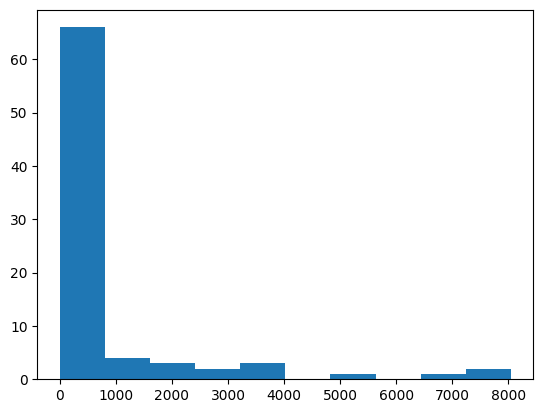

In [22]:
import matplotlib.pyplot as plt
plt.hist(found_ranks)
plt.show()

We can add a little more context to see what star we're talking about:

In [4]:
all_reviews = pd.read_json('data/preprocessed/reviews.jsonl', lines=True)
source_record = all_reviews.loc[all_reviews["doi"] == example["source_doi"]].iloc[0]
print(source_record)

bibcode                                         1992ARA&A..30..113K
abstract          Solar flare and coronal mass ejection (CME) ob...
aff                                            [Boston College, MA]
author                                              [Kahler, S. W.]
bibstem                                          [ARA&A, ARA&A..30]
doctype                                                     article
doi                             10.1146/annurev.aa.30.090192.000553
id                                                          1840100
pubdate                                                  1992-01-01
title                      Solar flares and coronal mass ejections.
read_count                                                        7
reference         [1852RSPT..142..103S, 1859MNRAS..20...13C, 190...
citation_count                                                  463
citation          [1992LNP...399....1S, 1993AZh....70..165C, 199...
body              Annu. Rev. Astron. Astrophys. 

In [5]:
idx = example['sent_idx']
pprint(source_record.body_sentences[idx-3:idx+1])

['Compared with photospheric abundances, the coronal abundances are known to '
 'be deficient in elements with a first ionization potential exceeding about 9 '
 'ev (Meyer 1985).',
 'Thus, the Breneman & Stone (1985) observations rule out a SEP source with '
 'photospheric abundances.',
 'There is now some evidence to suggest that elemental abundances of flare '
 'plasmas more closely match the photospheric rather than the coronal '
 'abundances (Feldman & Widing 1990), perhaps because the photospheric '
 'material is the primary source of the heated flare plasma.',
 'The work of Widing & Feldman (1989) suggests a fundamental distinction in '
 'elemental abundances between closed and open magnetic structures, matching '
 'the nominal photospheric and coronal abundances, respectively.']


Next let's embed the sentence and get query results. We'll want to know
1. At what distance do we find the target doi?
1. For any closer results, what is in their chunks?

In [6]:
embedder = get_embedder(model_name='BAAI/bge-small-en', device=device, normalize=True)
query_vector = embedder(example['sent_no_cit'])

In [7]:
query_results = db.query_vector_column(
    query_vector=query_vector,
    table_name='lib',
    target_column='bge',
    metric='vector_cosine_ops',
    pubdate=example.pubdate,
    use_index=True,
    top_k = 100_000,
    probes=100
)

  Query execution time: 3.87 seconds


Let's do a reality check on the results:
1. Did you get all `top_k` results?
1. Is the target doi in the top k results?

In [8]:
print(f" Got {len(query_results)} results")
result_dois = set(result.doi for result in query_results)
print(f" Found {len(result_dois)} unique DOIs")

target_doi = example['citation_dois'][0]
print(f"Target doi in the top k: {target_doi in result_dois}")

 Got 100000 results
 Found 10221 unique DOIs
Target doi in the top k: True


We found the target doi in the results. At what rank and distance was it found?

In [9]:
target_idx = -1
for i, result in enumerate(query_results):
    if result.doi == target_doi:
        target_idx = i
        print(f"Rank: {target_idx+1}")
        print(f"Distance: {result.distance}")
        break


Rank: 40
Distance: 0.1385815657030588


This example was the 40th closest to the query. Its chunk:

In [10]:
target_query_result = query_results[target_idx]
pprint(target_query_result.pubdate)
pprint(target_query_result.chunk)

datetime.date(1989, 9, 1)
('Furthermore, the abundance variations are correlated with the type of '
 'magnetic field topologv observed. Comparison of Mg vm 315.02 Â with Si vm '
 '319.84 A indicates that the magnesium abundance is relatively unchanged, so '
 'that the variations primarily reflect changes in the abundance of neon. '
 'Meyer (1985) suggested that the apparent depletion of ele- 1049 Ne VI 40 I. '
 'I 4 Mg VI 400.66 Fig. 4.—(a) The Ne vu 465/Ca ix 466 intensity ratio plotted '
 'against the Ne vi 401/Mg vi 400 intensity ratio from the observations in '
 'Table 1 and an impulsive flare showing the variation in the neon abundance '
 'relative to calcium or magnesium, (b) The Ne vii/Ca ix ratio divided by the '
 'Ne vi/Mg vi ratio in 4(a) showing the smaller variation in the Mg/Ca '
 'abundance ratio. ments with high-first ionization potentials (FIP) in the '
 'corona compared to low-FIP elements could be explained by assuming a '
 'separation process at the base of the coron

This looks like a quality citation. The review says this paper suggests there exist different element abundances between closed and open magnetic structures, and this chunk aligns with that claim.

What did the embedder consider even more similar than this chunk? What were the top chunks?

In [11]:
top = query_results[0]
pprint(top.chunk)

('3, 1969 Thermal continuum radiation 377 carried out. The variation of the '
 'ratio g(Z, T, c/X)lg(i, T, c/X) was checked at a number of wavelengths and '
 'temperatures in the ranges o*8 to ioo*o io6 °K and i to 30 Â for the twelve '
 'elements listed in Table I. The variations found in the ratio of the Gaunt '
 'factors would lead to fluctuations of up to 20 per cent in the value of the '
 'bracketed term in equation (6). These fluctuations are similar to those '
 'noted by Hovenier who found variations of up to 15 per cent in this term. '
 'Table I shows values of the bracketed term in equation (5) at a temperature '
 'of 5*0 io6 °K and a wavelength of 5 Â. Two sets of element abundances were '
 'employed. For the corona the abundance values used are those of Pottasch '
 '(1967) and Jordan (1968). In cases where these results have disagreed, an '
 'average value Table I Dependence of free-free flux on element abundances '
 'Element H He C N O Ne Mg Si S Ar Ca Fe Coronal abundances

This chunk is also talking about variation in abundances as well as corona.

In [12]:
print(f"Top pubdate: {top.pubdate}")
print(f"Example pubdate: {example.pubdate}")
print(f"Target pubdate: {target_query_result.pubdate}")

Top pubdate: 1969-01-01
Example pubdate: 1992-01-01
Target pubdate: 1989-09-01


In this case the top ranked result's pubdate was published much earlier than the target pubdate. Should there be a preference for newer publications?

In [13]:
# print all the pubdates for records ranked higher than the target
pprint([result.pubdate for result in query_results[:target_idx]])

[datetime.date(1969, 1, 1),
 datetime.date(1989, 9, 1),
 datetime.date(1977, 5, 1),
 datetime.date(1975, 10, 1),
 datetime.date(1974, 7, 1),
 datetime.date(1971, 12, 1),
 datetime.date(1969, 1, 1),
 datetime.date(1975, 12, 1),
 datetime.date(1984, 1, 1),
 datetime.date(1965, 2, 1),
 datetime.date(1974, 1, 1),
 datetime.date(1988, 9, 1),
 datetime.date(1969, 1, 1),
 datetime.date(1991, 11, 1),
 datetime.date(1984, 1, 1),
 datetime.date(1980, 6, 1),
 datetime.date(1969, 1, 1),
 datetime.date(1975, 10, 1),
 datetime.date(1985, 1, 1),
 datetime.date(1972, 12, 1),
 datetime.date(1985, 1, 1),
 datetime.date(1971, 12, 1),
 datetime.date(1975, 10, 1),
 datetime.date(1963, 4, 1),
 datetime.date(1981, 10, 1),
 datetime.date(1975, 12, 1),
 datetime.date(1971, 5, 1),
 datetime.date(1982, 11, 1),
 datetime.date(1961, 5, 1),
 datetime.date(1975, 10, 1),
 datetime.date(1989, 9, 1),
 datetime.date(1966, 9, 1),
 datetime.date(1960, 11, 1),
 datetime.date(1985, 1, 1),
 datetime.date(1960, 11, 1),
 datet

These were all earlier except the one at index 1, which has the same pubdate as the target. But it's not the target?

In [14]:
second_result = query_results[1]
pprint(second_result.pubdate)
pprint(second_result.doi)
pprint(second_result.chunk)

third_result = query_results[2]
pprint(third_result.pubdate)
pprint(third_result.doi)
pprint(third_result.chunk)

datetime.date(1989, 9, 1)
'10.1086/167855'
('Furthermore, some of the variations of the observed spectrum are not simply '
 'due directly to the higher abundance of individual elements near the '
 'magnetic pole, but to the changes in atmospheric structure induced by the '
 'combination of all such abundance variations acting in concert. Two other '
 'features of the inferred abundance distributions are notable. First, the '
 'highest abundance regions found for the already cosmically abundant elements '
 'Si and Fe are rather large; in our model the two rings out to a = 72° are '
 'both high-abundance regions for these elements relative to the equatorial '
 'abundances. In contrast, the polar caps of the cosmically lower abundance '
 'elements Ti and Cr are smaller; for both these elements the midlatitude '
 '(ring 2) abundances are considerably smaller than at the pole. A second, '
 'possibly significant feature of the abundance models is that all three '
 'iron-peak elements have qu

Let's repeat this process with BERT and see if the results significantly change

In [15]:
bert_embedder = get_embedder(model_name='bert-base-uncased', device=device, normalize=False)
bert_query_vector = bert_embedder(example['sent_no_cit'])[0]

bert_query_results = db.query_vector_column(
    query_vector=bert_query_vector,
    table_name='lib',
    target_column='bert',
    metric='vector_cosine_ops',
    pubdate=example.pubdate,
    use_index=True,
    top_k = 100_000,
    probes=100
)

  Query execution time: 3.51 seconds


In [16]:
print(f" Got {len(bert_query_results)} results")
bert_result_dois = set(result.doi for result in bert_query_results)
print(f" Found {len(bert_result_dois)} unique DOIs")

target_doi = example["citation_dois"][0]
print(f"Target doi in the top k: {target_doi in bert_result_dois}")

 Got 100000 results
 Found 11295 unique DOIs
Target doi in the top k: True


In [17]:
bert_target_idx = -1
for i, result in enumerate(bert_query_results):
    if result.doi == target_doi:
        bert_target_idx = i
        print(f"Rank: {bert_target_idx+1}")
        print(f"Distance: {result.distance}")
        break

Rank: 60110
Distance: 0.19633366453420387


In this case the rank is much worse and the distance is greater (0.1963 compared to 0.1356).

Here's the closest chunk from the target DOI:

In [18]:
bert_target_query_result = bert_query_results[target_idx]
pprint(bert_target_query_result.pubdate)
pprint(bert_target_query_result.doi)
pprint(bert_target_query_result.chunk)

datetime.date(1983, 8, 1)
'10.1086/161188'
('The numbers and discussions in the preceding paragraphs cannot be accepted '
 'uncritically at the present time. They mostly demonstrate what can be '
 'achieved with data of this sort, and the directions we must go for '
 'improvement. This work shows at least the general consistency of several '
 'theories that predict phenomena in the domain of the planetaries. With '
 'better N/O ratios, a full set of He/H ratios, improved distances, and '
 'continued improvement of the theory relating nebular abundances to stellar '
 'mass, much finer discrimination of the above parameters should be possible, '
 'which will ultimately lead toward accurate values for total mass loss and '
 'the lower mass limit for carbon-core supernova production. V. SUMMARY As a '
 'result of the new data and analyses of large planetary nebulae presented in '
 'this paper, we begin to see detailed agreement between the theory of '
 'evolution of planetary nebulae and t

What did BERT consider closer?

In [19]:
bert_top = bert_query_results[0]
pprint(bert_top.chunk)
pprint(f"Distance: {bert_top.distance}")

('It is also supported by the work of Walbom, Nichols-Bohlin, and Panek (1985, '
 'and references therein), who have shown that the morphology of UV mass-loss '
 'features follows a close relationship with spectral classification; the '
 'tight correlations which they have demonstrated would not be observed if '
 'variability were a dominant factor. In the present paper we take advantage '
 'of this result to study the principal wind diagnostics of a complete sample '
 'of O stars observed with IUE, using in most cases single spectra of each '
 'object.')
'Distance: 0.09337484467471313'


This chunk does not seem particularly relevant to the query.

Although I don't have astrobert locally, we can try to see what the distance would be between some of these chunks by embedding them and taking the cosine distance.

In [20]:
astrobert_embedder = get_embedder(model_name="adsabs/astroBERT", device=device, normalize=False)
astrobert_query_vector = astrobert_embedder(example['sent_no_cit'])[0]

In [21]:
bge_top_chunk = query_results[0].chunk
bge_second_chunk = query_results[1].chunk
bge_target_chunk = query_results[39].chunk

bge_top_vector = astrobert_embedder(bge_top_chunk)[0]
bge_second_vector = astrobert_embedder(bge_second_chunk)[0]
bge_target_vector = astrobert_embedder(bge_target_chunk)[0]

In [22]:
from scipy.spatial.distance import cosine

print(f"Astrobert distance between query and target: {cosine(astrobert_query_vector, bge_target_vector)}")
print(f"Astrobert distance between query and top: {cosine(astrobert_query_vector, bge_top_vector)}")
print(f"Astrobert distance between query and second: {cosine(astrobert_query_vector, bge_second_vector)}")

Astrobert distance between query and target: 0.19301333222582617
Astrobert distance between query and top: 0.29277018026509505
Astrobert distance between query and second: 0.2768538911744477


Let's try this again with prev_n sentences in the query. Does some additional context help?

In [23]:
from TextEnrichers import get_enricher
enricher_prev_3 = get_enricher(name='add_prev_3', path_to_data='data/preprocessed/reviews.jsonl')

In [24]:
enriched_text = enricher_prev_3(pd.DataFrame([example]))[0]
pprint(enriched_text)

('Compared with photospheric abundances, the coronal abundances are known to '
 'be deficient in elements with a first ionization potential exceeding about 9 '
 'ev (Meyer 1985). Thus, the Breneman & Stone (1985) observations rule out a '
 'SEP source with photospheric abundances. There is now some evidence to '
 'suggest that elemental abundances of flare plasmas more closely match the '
 'photospheric rather than the coronal abundances (Feldman & Widing 1990), '
 'perhaps because the photospheric material is the primary source of the '
 'heated flare plasma. The work of  suggests a fundamental distinction in '
 'elemental abundances between closed and open magnetic structures, matching '
 'the nominal photospheric and coronal abundances, respectively.')


Now let's use the embedding of this context-enriched input to query the database and see if makes the target doi chunks closer or higher ranked.

In [25]:
enriched_query_vector = embedder([enriched_text])[0]
enriched_query_results = db.query_vector_column(
    query_vector=enriched_query_vector,
    table_name="lib",
    target_column="bge",
    metric="vector_cosine_ops",
    pubdate=example.pubdate,
    use_index=True,
    top_k=100_000,
    probes=100,
)

  Query execution time: 2.35 seconds


In [26]:
print(f" Got {len(enriched_query_results)} results")
result_dois = set(result.doi for result in enriched_query_results)
print(f" Found {len(result_dois)} unique DOIs")

target_doi = example["citation_dois"][0]
print(f"Target doi in the top k: {target_doi in result_dois}")

 Got 100000 results
 Found 9474 unique DOIs
Target doi in the top k: True


In [28]:
target_idx = -1
for i, result in enumerate(enriched_query_results):
    if result.doi == target_doi:
        target_idx = i
        print(f"Rank: {target_idx+1}")
        print(f"Distance: {result.distance}")
        break

Rank: 7
Distance: 0.04716029903770347


Much nicer! The enriched version is 7th closest (down from 40) with a distance of 0.0471 (down from 0.1386)

So what were some of the records that were still even closer?

In [29]:
for i in range(3):
    print(f"Rank: {i+1}")
    print(f"Distance: {enriched_query_results[i].distance}")
    pprint(enriched_query_results[i].chunk)
    print(enriched_query_results[i].pubdate)
    print(enriched_query_results[i].doi)
    print("====")

Rank: 1
Distance: 0.03745414578920525
('Corresponding values of coronal and photospheric abundances (Withbroe, 1971) '
 'are listed for comparison. (Abundance values determined using solar cosmic '
 'ray data are not listed due to the present uncertainty in accounting for '
 'possible fractionation due to unknown energetic particle acceleration '
 'mechanisms and propagation effects.) It has already been noted by Withbroe '
 '(1971) that, within experimental errors (a factor of 2), photospheric and '
 'coronal abundances are equal. Thus there appears to be no direct '
 'experimental evidence in support of a steady-state elemental fractionation '
 'between the photosphere and corona as large as a factor of 2. Comparison of '
 'the average values of solar wind 0, Si and Fe abundances determined here '
 'with corresponding values determined in the lower corona shows no evidence '
 'of a steady-state elemental fractionation within the corona as well. However '
 'experimental errors are lar

Let's try summarizing the first 40 chunks from bge and see if that can focus embeddings on what's important in each chunk.